In [1]:
import keras
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline

Using TensorFlow backend.
/Users/Abhi/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Effect of News on Stock Price Movement

This project consists of 2 main parts, sentiment analysis and multivariate regression. 

## Problem Statement
Given a stock's previous data and some news information, can we predict if it's price will go up or down?

## Simplifying the Problem

Since we just want to maximize stock return, we can reduce this problem to binary classification, 0 representing a loss (net change < 0) and 1 representing a win (net change ≥ 0). Now, the second part of this problem is also classification.

In order to effectively predict the effect of news on stock prices, the news must have a sentiment score, which can be applied to a separate model that predicts the effect of this sentiment on the stock's price.

Also, due to time constraints, I've opted to train and test the model on a single index, the Dow Jones industrial average.

I began by gathering news data, as well as corresponding stock data, from this link: https://www.kaggle.com/aaron7sun/stocknews#RedditNews.csv

## DOW Jones From 2008 to 2016

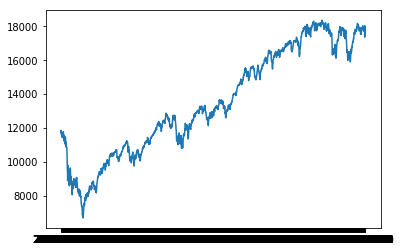

In [63]:
plt.plot(stocks['Date'], stocks['High'])
plt.show()

## Overview of Pipeline
#### News, Stock Chart $\rightarrow$ Sentiment Class for Stock $\rightarrow$ Prediction (Increase/Decrease)

## Sentiment Analysis Model
This relies heavily on NLTK. Given more time, I'd use the implementation from Homework 6.

In [59]:
class SentimentModel:
    def __init__(self):
        self.model = SentimentIntensityAnalyzer()
    
    def predict(self, text):
        tup = self.model.polarity_scores(text)['compound']
        sent = 1 if tup >= 0 else 0
        return sent
    
    def net_sentiment(self, text_list):
        total = 0
        
        for t in text_list:
            tup = self.model.polarity_scores(str(t))['compound']
            total += tup
        
        return total 
        
            
m = SentimentModel()
tests = ['These 20 Companies have had a great year.', 'Many businesses are experiencing loss.', 'It has been a successful year for tech.']
for t in tests:
    print("{} : {}".format(t, m.predict(t)))  
print("Net sentiment: {}".format(m.net_sentiment(tests)))

These 20 Companies have had a great year. : 1
Many businesses are experiencing loss. : 0
It has been a successful year for tech. : 1
Net sentiment: 0.8926000000000001


## Stock Data

In [2]:
stocks = pd.read_csv('stocks.csv')
news = pd.read_csv('stocknews/Combined_News_DJIA.csv')

In [6]:
#Data Cleaning, adding sentiment scores to each row
"""return_ints = []
nets = []

for i in range(1989):
    news_row = news.loc[i]
    stock_row = stocks.loc[i]
    
    news_texts = [news_row['Top{}'.format(x)] for x in range(1, 26)]
    net_score = m.net_sentiment(news_texts)
    
    nets.append(net_score)
    
    inc = stock_row['return']
    as_int = 1 if inc else 0
    return_ints.append(as_int)
    
score_series = pd.Series(nets)
ints = pd.Series(return_ints)

stocks['return'] = ints.values
stocks['sentiment'] = score_series.values
"""
prev_close = [11431.43] + list(stocks['Close'])[:-1]
prev_return = [0] + list(stocks['return'])[:-1]

stocks['previous return'] = prev_return
stocks['previous close'] = prev_close
stocks['change'] = stocks['Close']-stocks['Open']

def class_data(stocks):
    X, y = stocks[['Open', 'previous return', 'previous close', 'sentiment']], stocks['return']
    split = int(len(X)*0.7)
    end_num = len(X)-split
    X_train, y_train, X_test, y_test = X.head(split), y[:split], X.tail(end_num), y[split:]
    
    return (X_train, list(y_train), X_test, list(y_test))

def reg_data(stocks):
    X, y = stocks[['Open', 'previous return', 'previous close', 'sentiment']], stocks['change']
    split = int(len(X)*0.7)
    end_num = len(X)-split
    X_train, y_train, X_test, y_test = X.head(split), y[:split], X.tail(end_num), y[split:]
    
    return (X_train, list(y_train), X_test, list(y_test))

X_train, y_train, X_test, y_test = class_data(stocks)
classifier_data = [X_train, y_train, X_test, y_test]

X_train, y_train, X_test, y_test = reg_data(stocks)
regressor_data = [X_train, y_train, X_test, y_test]

stocks.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Adj Close,return,sentiment,previous return,previous close,change
0,1988,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,1,-7.7360,0,11431.430000,302.230468
1,1987,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1,-3.0185,1,11734.320312,52.679687
2,1986,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,1,-5.4389,1,11782.349609,-139.230468
3,1985,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,1,-4.2181,1,11642.469727,-99.849609
4,1984,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,0,-3.2687,1,11532.959961,83.859376


## Sentiment $\rightarrow$ Stock Prediction

At this point, we can use the 'Open', 'previous return', 'previous close', and 'sentiment' columns to predict either 'return' or 'change'. By predicting one of two columns, we can re-model this problem as either classification or regression.

### Goal
Ideally, we need classification accuracy to be at least 50%, and regression accuracy (mean absolute percent error) to be within 15%. 

## Approaches
I implemented neural network, random forest, and a few other approaches

In [4]:
#Neural Network (keras)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import adam

class StockPredict:
    
    def __init__(self):
        model = Sequential()
        model.add(Dense(64, input_dim=4, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='tanh'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        
        self.nn = model
        
        self.nn.compile(loss='binary_crossentropy',
              optimizer='rmsprop', metrics=['accuracy'])
        
    def train(self, dataX, dataY, e=50, batch=32):
        self.nn.fit(X_train, y_train, epochs=e, batch_size=batch, verbose=0)
        
    def predict(self, x):
        return self.nn.predict(x)
        
    def score(self, testX, testY, bs=100):
        return self.nn.evaluate(testX, testY, batch_size=bs)

In [5]:
stock_model = StockPredict()

X_train, y_train, X_test, y_test = classifier_data

stock_model.train(X_train, y_train, e=30)
score = stock_model.score(X_test, y_test)

score

597/597 [==============================] - 0s 269us/step


[0.6907956510332961, 0.5376884302801423]

### Error Function for sklearn models

In [ ]:
def model_error(model, x, y, classifier=True):
    index = 0
    error = 0
    
    for yhat in model.predict(x):
        ystar = y[index]
        
        if classifier:
            if yhat == ystar:
                error += 1
        else:
            error += abs(yhat-ystar)

        index += 1
        
    return error/index

In [17]:
#Random Forests
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

model = RandomForestRegressor()
X_train, y_train, X_test, y_test = regressor_data
model.fit(X_train, y_train)
score = model_error(model, X_test, y_test, classifier=False)
print("Regression Score (MAPE)%: {}".format(score))

model = RandomForestClassifier()
X_train, y_train, X_test, y_test = classifier_data
model.fit(X_train, y_train)
score = model_error(model, X_test, y_test, classifier=True)
print("Classification Score: {}%".format(score))

Regression Score (MAPE): 118.94290698442212
Classification Score: 0.5309882747068677%


/Users/Abhi/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Abhi/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [19]:
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier, SGDRegressor

model = LogisticRegression(solver='lbfgs')
X_train, y_train, X_test, y_test = classifier_data
model.fit(X_train, y_train)
score = model_error(model, X_test, y_test, classifier=True)
print("Classification Score: {}%".format(score))

model = LinearRegression()
X_train, y_train, X_test, y_test = regressor_data
model.fit(X_train, y_train)
score = model_error(model, X_test, y_test, classifier=False)
print("Regression Score (MAPE): {}%".format(score))

Classification Score: 0.5376884422110553%
Regression Score (MAPE): 110.11160779466063%
